# Réseau neuronal convolutif

<img src="cnn_diagram.png"  style="width: 60%; height: 60%"/>

In [2]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.
x_test  = x_test/255.
y_train = to_categorical(y_train, dtype='int8')
y_test  = to_categorical(y_test, dtype='int8')

train_size = x_train.shape[0] # Nombre de ligne de la matrice x_train
test_size  = x_test.shape[0]

## Hyperparamètres

In [4]:
#Nombre d'époques pour l'apprentissage:
n_epoch = 15

# Taille du batch d'entraînement:
batch_size = 100

# Incrément pour l'apprentissage
starter_learning_rate = 0.003
# taux de décroissance du pas d'apprentissage
decay_rate = 0.7
# Nombre d'époques à faire avant de changer de pas
decay_epoch = 3

# dropout: taux de neurones à supprimer
# seulement entre la couche de convolution à 12 canaux et couche de 200 neurones complètement connectée
dropout = 0.25

## Graphe

Transformation de l'entrée en un tenseur à 4 dimensions pour l'utilisation dans la fonction `tf.nn.conv2d`. La dernière dimension indique le nombre de canaux d'entrée (3 pour une image en couleur, ici un seul car nos images sont en niveaux de gris).

In [5]:
X = tf.placeholder(tf.float32, shape=(None,28,28))
Xd = tf.reshape(X, [-1,28,28,1])

Le tenseur W1 correspond au filtre utilisé. La troisième dimension indique le nombre de canaux d'entrée (ici 1) et la quatrième le nombre choisi de canaux de sortie. Ce nombre correspond aussi au nombre de biais qu'il faudra utiliser pour cette couche.

In [6]:
W1 = tf.Variable(tf.truncated_normal([5,5,1,4], stddev=0.1))
# Initialisation des biais 0.1
b1 = tf.Variable(tf.ones([4])/10)
stride1 = 1
Y1cnv = tf.nn.conv2d(Xd, W1, strides=[1, stride1, stride1, 1], padding='SAME')
Y1 = tf.nn.relu(Y1cnv + b1)

W2 = tf.Variable(tf.truncated_normal([4,4,4,8], stddev=0.1))
b2 = tf.Variable(tf.ones([8])/10)
stride2 = 2
Y2cnv = tf.nn.conv2d(Y1, W2, strides=[1,stride2,stride2,1], padding='SAME')
Y2 = tf.nn.relu(Y2cnv + b2)

W3 = tf.Variable(tf.truncated_normal([4,4,8,12], stddev=0.1))
b3 = tf.Variable(tf.ones([12])/10)
stride3 = 2
Y3cnv = tf.nn.conv2d(Y2, W3, strides=[1,stride3,stride3,1], padding='SAME')
Y3 = tf.nn.relu(Y3cnv + b3)

Instructions for updating:
Colocations handled automatically by placer.


On transforme la sortie Y3 en un simple vecteur que l'on va connecter complètement à la couche suivante de 200 neurones

In [7]:
Y3d = tf.reshape(Y3, [-1, 7*7*12])

# dropout_rate: probabilité qu'un neurone soit supprimé (doit être = 0 lors de la phase de test)
dropout_rate = tf.placeholder(tf.float32)
W4 = tf.Variable(tf.truncated_normal([7*7*12,200], stddev=0.1))
b4 = tf.Variable(tf.ones([200])/10)
Y4 = tf.nn.relu(tf.matmul(Y3d,W4) + b4)
Y4d = tf.nn.dropout(Y4, rate=dropout_rate)

W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
b5 = tf.Variable(tf.zeros([10]))
Ylogits = tf.matmul(Y4d,W5) + b5
Y = tf.nn.softmax(Ylogits)

In [8]:
Y_ = tf.placeholder(tf.float32, shape=(None,10))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_sum(cross_entropy)

is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_epoch*train_size//batch_size, decay_rate, staircase=True)

# Optimisation
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy, global_step=global_step)

In [9]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
i_best = 0
accuracy_best = 0

In [10]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
print('Epoque: ')

for i in range(n_epoch*train_size//100):
    epoch = (i*100)//train_size + 1
    
    # Chargement d'un batch d'images et de réponses correctes correspondantes
    batch_train_X  = x_train[(i*100)%train_size:((i+1)*100)%train_size]
    batch_train_Y_ = y_train[(i*100)%train_size:((i+1)*100)%train_size]
    # Dictionnaire de données en entrée
    train_data = {X: batch_train_X, Y_: batch_train_Y_, dropout_rate:dropout}

    # train
    sess.run(train_step, feed_dict=train_data)
    
    # Visualisation de la progression
    if not (i*100)%(train_size):
        #Affichage de l'évolution en ligne
        print(epoch, ' ', end='')
    if not i%50:
        # Pour le batch d'entraînement
        acc, loss  = sess.run([accuracy, cross_entropy], feed_dict=train_data)
        accuracy_train.append(acc)
        loss_train.append(loss/batch_size)
        
        # Pour le test: évaluation sur tout l'ensemble des données
        test_data = {X: x_test, Y_: y_test, dropout_rate:0}
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
        accuracy_test.append(acc)
        loss_test.append(loss/test_size)
        if acc>accuracy_best:
            accuracy_best = acc
            i_best = i

Epoque: 
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  

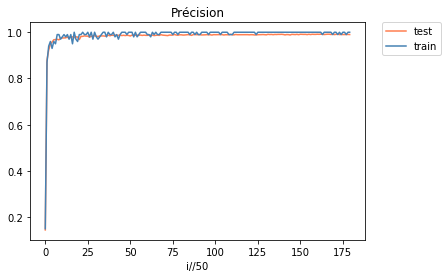

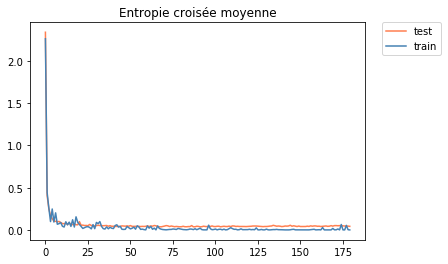

Best score for iteration 8100 	| Accuracy = 0.9915


In [11]:
# Représentation des résultats
# Précision
plt.plot(accuracy_test, c='coral', label='test')
plt.plot(accuracy_train, c='steelblue', label='train')
plt.xlabel('i//50')
plt.title('Précision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Fonction de coût
plt.plot(loss_test, c='coral', label='test')
plt.plot(loss_train, c='steelblue', label='train')
plt.title('Entropie croisée moyenne')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Meilleur résultat sur un batch de test
print("Best score for iteration {} \t| Accuracy = {:.4f}".format(i_best, accuracy_best ))

In [12]:
sess.close()

Best score for iteration 8100 	| Accuracy = 0.9915